In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [2]:
DATA_PATH = "C:/Users/ash/Desktop/0503 Dust Sensor"
def load_csv_data(file_name):
    csv_path = os.path.join(DATA_PATH, file_name)
    return pd.read_csv(csv_path)

data_list = []
for i in range(2, 6):
    data_list.append(load_csv_data("new_sensor" + str(i) + ".csv"))

<AxesSubplot:>

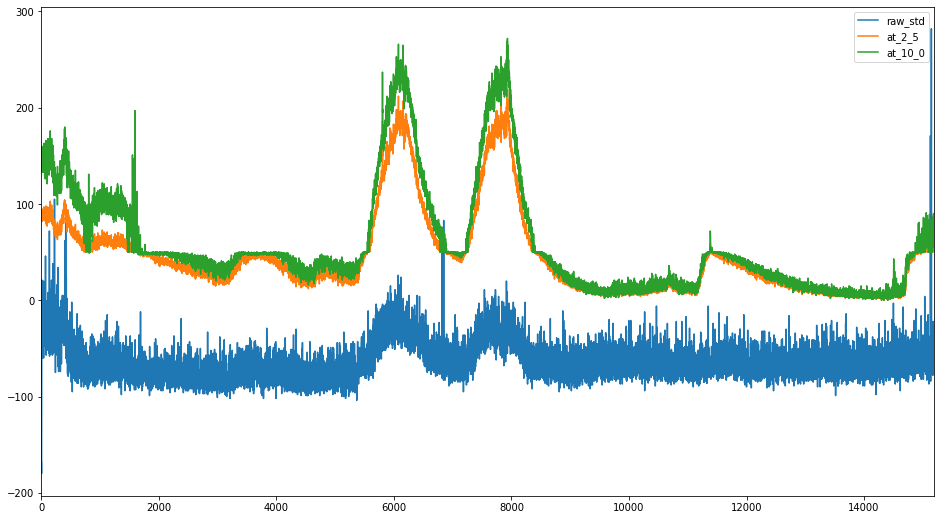

In [48]:
cols = ["raw_std", "smooth_std", "raw_cali", "smooth_cali", "at_2_5", "at_10_0"]
new_data_list = []
for data in data_list:
    new_data_list.append(data[cols])

new_data_list[3]
new_data_list[3].plot(y=['raw_std', 'at_2_5', 'at_10_0'], use_index=True, figsize=(16, 9), xlim=(0, len(new_data_list[3])))

In [4]:
new_data_list[0].loc[i:i, 'raw_std']

5   -6
Name: raw_std, dtype: int64

In [49]:
import math

smooth_data_list = []
split_data_list = []
SMOOTH_LENGTH = 200
START_INDEX, END_INDEX = 500, 8500

for data in new_data_list:
    ls = []
    raw_ls = []
    for i in range(START_INDEX, END_INDEX):
        avg_dict = {}
        raw_dict = {}
        for col in cols:
            if col == 'raw_std' or col == 'raw_cali':
                avg_dict[col] = data.loc[i, col]
            else:
                avg_dict[col] = sum(data.loc[i:i + SMOOTH_LENGTH, col]) // SMOOTH_LENGTH
            raw_dict[col] = int(data.loc[i:i, col])

        ls.append(avg_dict)
        raw_ls.append(raw_dict)
        
    smooth_data_list.append(pd.DataFrame(ls))
    split_data_list.append(pd.DataFrame(raw_ls))
    
smooth_data_list[0]

,raw_std,smooth_std,raw_cali,smooth_cali,at_2_5,at_10_0
0,-35,-24,22,32,56,120
1,-32,-24,25,32,56,119
2,3,-24,55,31,56,119
3,-4,-25,49,31,56,119
4,-10,-25,44,31,56,119
...,...,...,...,...,...,...
7995,-9,-21,44,34,167,233
7996,-25,-21,31,34,166,232
7997,-38,-21,20,34,166,232
7998,-18,-21,36,34,166,231


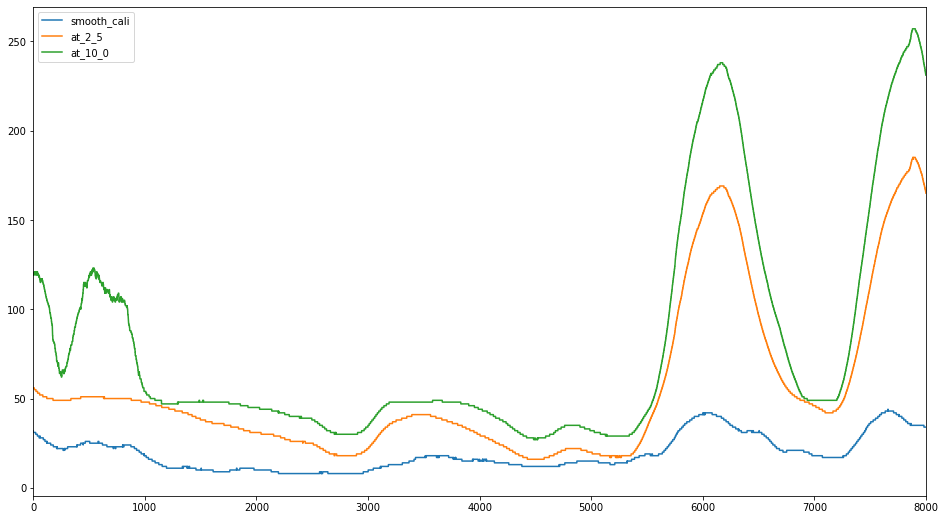

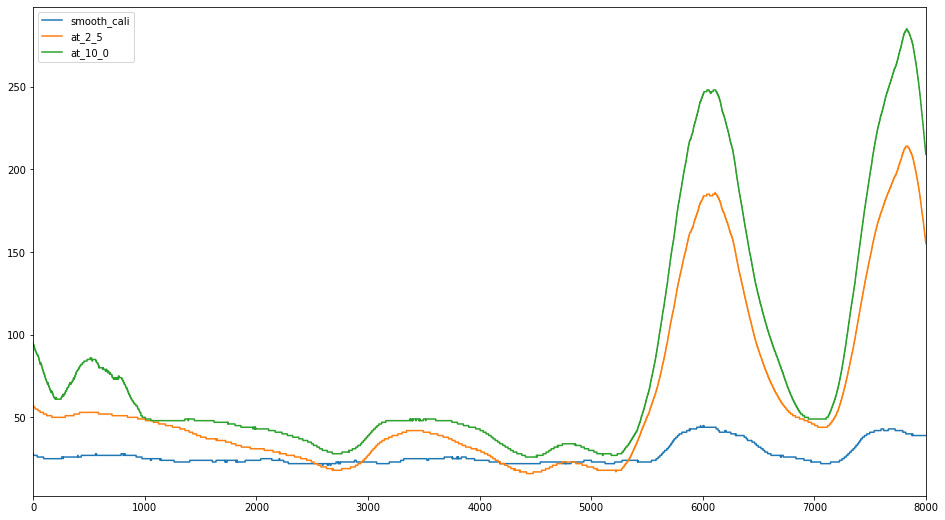

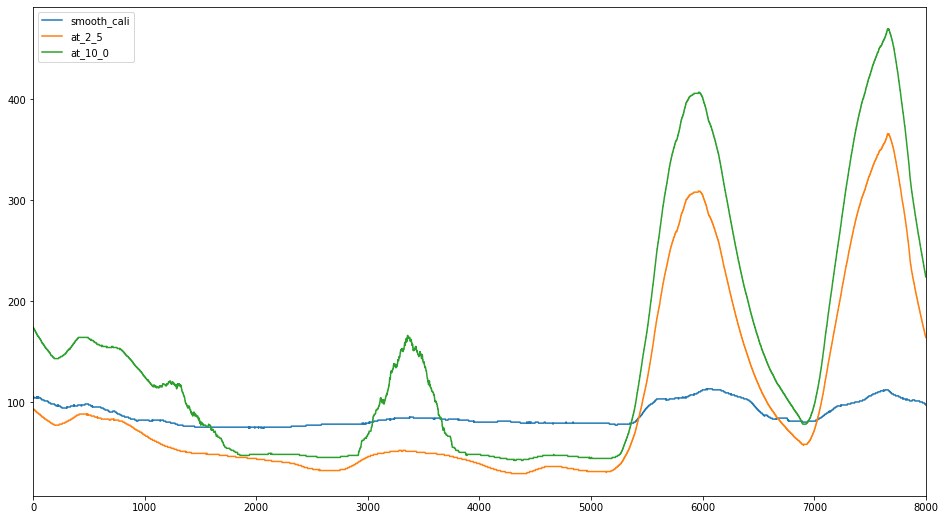

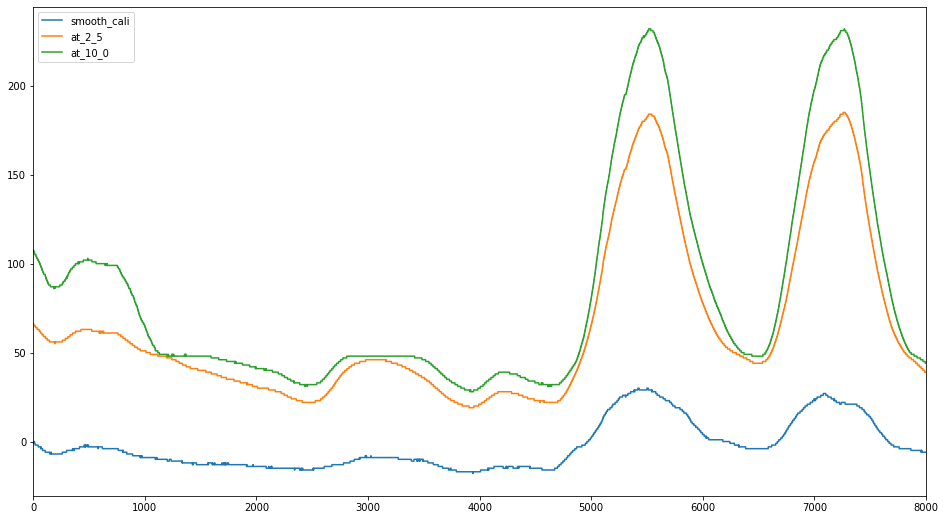

In [50]:
for ls in smooth_data_list:
    ls.plot(y=['smooth_cali', 'at_2_5', 'at_10_0'], use_index=True, figsize=(16, 9), xlim=(0, len(ls)))
#     plt.xlim(0, len(ls))
#     plt.show()

In [51]:
plot_index = 0
data = smooth_data_list[plot_index]
raw_data = split_data_list[plot_index]

WINDOW_SIZE = 5
split_size = (len(data) // 20) * 16
train_set, test_set = data[:split_size], data[split_size:]

# make_dataset()
# WINDOW_SIZE = 3인 경우의 examples
#
# --1--2--3--4--5--6--7--8--9--..
#  [1--2--3]
#     [2--3--4]
#        [3--4--5]...
#
def make_dataset(data, label, window_size=WINDOW_SIZE):
    feature_list = []
    label_list = []
    for i in range(len(data) - window_size):
        feature_list.append(np.array(data.iloc[i:i + window_size]))
        label_list.append(np.array(label.iloc[i + window_size]))
    return np.array(feature_list), np.array(label_list)

In [70]:
from sklearn.model_selection import train_test_split

feature_cols = ['raw_cali']
label_cols = ['at_2_5']

train_feature, train_label = train_set[feature_cols], train_set[label_cols]
train_feature, train_label = make_dataset(train_feature, train_label, WINDOW_SIZE)
print("train_feature:", train_feature.shape)
print("train_label:  ", train_label.shape)

x_train, x_valid, y_train, y_valid = train_test_split(train_feature, train_label, test_size=0.2)
print("x_train:      ", x_train.shape)
print("x_valid:      ", x_valid.shape)

train_feature: (6395, 5, 1)
train_label:   (6395, 1)
x_train:       (5116, 5, 1)
x_valid:       (1279, 5, 1)


In [71]:
test_feature, test_label = test_set[feature_cols], test_set[label_cols]
test_feature, test_label = make_dataset(test_feature, test_label, WINDOW_SIZE)
test_feature.shape, test_label.shape

((1595, 5, 1), (1595, 1))

In [72]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Activation, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import optimizers

model = Sequential()
model.add(LSTM(units=8,
               input_shape=(train_feature.shape[1], train_feature.shape[2]),
               activation="relu",
               return_sequences=False))
# model.add(LSTM(units=256,
#                return_sequences=False))
model.add(Dense(1))


# model.compile(loss='mean_squared_error', optimizer=optimizers.RMSprop(), metrics=['accuracy'])
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 8)                 320       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 9         
Total params: 329
Trainable params: 329
Non-trainable params: 0
_________________________________________________________________


In [73]:
model_path = 'model'
filename = os.path.join(model_path, 'split_8001_6.h5')
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')


history = model.fit(x_train, y_train, 
                    epochs=30, 
                    batch_size=30, 
                    validation_data=(x_valid, y_valid),
                    callbacks=[checkpoint])

# model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuarcy'])
# early_stop = EarlyStopping(monitor='val_loss', patience=50)

# model_path = 'model'
# filename = os.path.join(model_path, 'tmp_checkpoint3.h5')
# checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

# history = model.fit(x_train, y_train, 
#                     epochs=50, 
#                     batch_size=20, 
#                     validation_data=(x_valid, y_valid), 
#                     callbacks=[early_stop, checkpoint])

Epoch 1/30
171/171 [==============================] - 1s 2ms/step - loss: 3187.9226 - val_loss: 551.7892

Epoch 00001: val_loss improved from inf to 551.78918, saving model to model\split_8001_6.h5
Epoch 2/30
171/171 [==============================] - 0s 936us/step - loss: 465.4315 - val_loss: 393.0487

Epoch 00002: val_loss improved from 551.78918 to 393.04871, saving model to model\split_8001_6.h5
Epoch 3/30
171/171 [==============================] - 0s 965us/step - loss: 377.6258 - val_loss: 379.1368

Epoch 00003: val_loss improved from 393.04871 to 379.13678, saving model to model\split_8001_6.h5
Epoch 4/30
171/171 [==============================] - 0s 965us/step - loss: 384.8921 - val_loss: 356.1401

Epoch 00004: val_loss improved from 379.13678 to 356.14014, saving model to model\split_8001_6.h5
Epoch 5/30
171/171 [==============================] - 0s 959us/step - loss: 360.4751 - val_loss: 342.0778

Epoch 00005: val_loss improved from 356.14014 to 342.07776, saving model to mode

(6395, 1) (6395, 1)


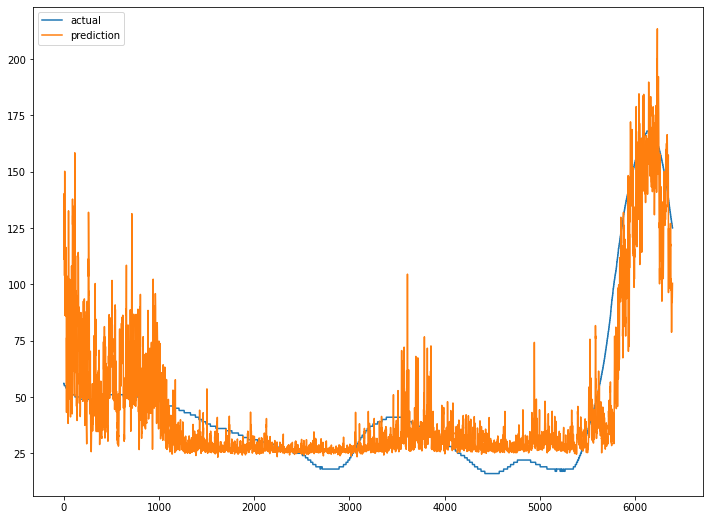

In [74]:
# model = history.history
pred = model.predict(train_feature)

print(pred.shape, train_label.shape)
# print(pred[:,:, :])

plt.figure(figsize=(12, 9))
plt.plot(train_label, label='actual')
plt.plot(pred, label='prediction')

# sns.lineplot(y=valid_datas[0]['high_pm10_0_at'], x=valid_datas[0]['time'])
plt.legend()
plt.show()

(1595, 1) (1595, 1)


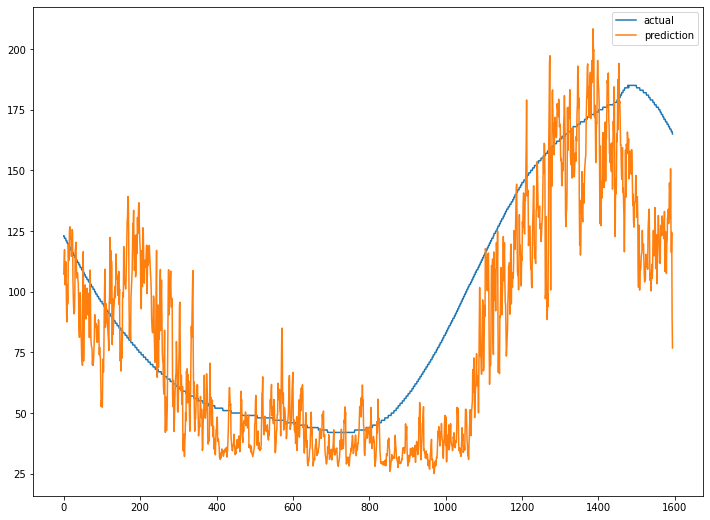

0.6664899929410881

In [75]:
# model = history.history
pred = model.predict(test_feature)

print(pred.shape, test_label.shape)
# print(pred[:,:, :])

plt.figure(figsize=(12, 9))
plt.plot(test_label, label='actual')
plt.plot(pred, label='prediction')

# sns.lineplot(y=valid_datas[0]['high_pm10_0_at'], x=valid_datas[0]['time'])
plt.legend()
plt.show()

from sklearn.metrics import r2_score
r2_score(test_label, pred)

In [21]:
raw_data

,raw_std,smooth_std,at_2_5,at_10_0
0,-35,-23,60,110
1,-32,-12,64,118
2,3,-6,69,127
3,-4,-11,67,128
4,-10,-16,61,112
...,...,...,...,...
7995,-9,-22,206,282
7996,-25,-30,184,253
7997,-38,-23,197,277
7998,-18,-19,207,295


<AxesSubplot:ylabel='raw_std'>

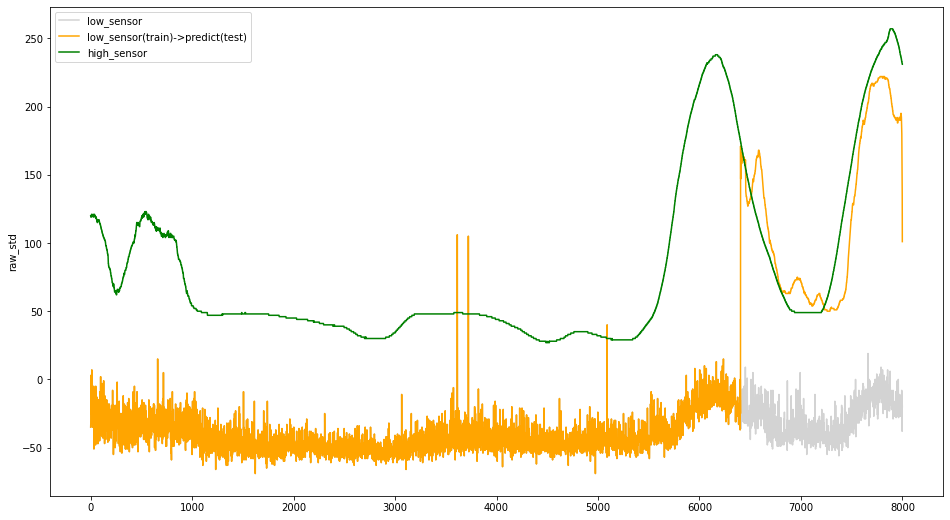

In [29]:
scale_cols = ['raw_std', 'at_2_5', 'at_10_0']
show_datas = data[scale_cols]
show_raw_datas = raw_data[scale_cols]

show_datas["predict"] = show_raw_datas["raw_std"]
test_datas = show_datas
for i in range(len(pred)):
    test_datas.at[split_size + WINDOW_SIZE + i, 'predict'] = pred[i][0]

smooth_datas = test_datas
SMOOTH = 50
for i in range(len(pred)):
    base = split_size + WINDOW_SIZE
    if i < SMOOTH:
        smooth_datas.at[base + i, 'predict'] \
            = sum(test_datas[base : base + i + 1]['predict']) // (i + 1)
    elif SMOOTH < len(pred) - i:
        smooth_datas.at[base + i, 'predict'] \
            = sum(test_datas[base + i - SMOOTH : base + i + SMOOTH]['predict']) // (2 * SMOOTH)
    else:
        smooth_datas.at[base + i, 'predict'] \
            = sum(test_datas[base + i: base + len(pred)]['predict']) // (len(pred) - i)
    
plt.figure(figsize=(16, 9))
sns.lineplot(y=show_raw_datas['raw_std'], x=show_raw_datas.index, color="lightgray", label='low_sensor')
sns.lineplot(y=smooth_datas['predict'], x=smooth_datas.index, color="orange", label='low_sensor(train)->predict(test)')
sns.lineplot(y=smooth_datas['at_10_0'], x=smooth_datas.index, color="green", label='high_sensor')

In [89]:
from sklearn.metrics import r2_score, mean_squared_error

data1 = smooth_data_list[0]['at_10_0'][6400:8000]
data2 = smooth_data_list[0]['raw_cali'][6400:8000]
print(r2_score(data1, data2))
print(mean_squared_error(data1, data2)**0.5)

data1 = smooth_data_list[0]['at_2_5'][6400:8000]
data2 = smooth_data_list[0]['raw_cali'][6400:8000]
print(r2_score(data1, data2))
print(mean_squared_error(data1, data2)**0.5)

data1 = smooth_data_list[0]['at_10_0'][6400:8000]
data2 = smooth_data_list[0]['smooth_cali'][6400:8000]
print(r2_score(data1, data2))
print(mean_squared_error(data1, data2)**0.5)

data1 = smooth_data_list[0]['at_2_5'][6400:8000]
data2 = smooth_data_list[0]['smooth_cali'][6400:8000]
print(r2_score(data1, data2))
print(mean_squared_error(data1, data2)**0.5)

-1.725332568168843
121.30346244027827
-1.5883550796647667
79.63992403311293
-1.7114510327532675
120.99413725466205
-1.5632663669556428
79.2530125610377


In [81]:
from scipy.stats import spearmanr
correlation = spearmanr(smooth_data_list[0].loc[6400:8000,['smooth_cali']],smooth_data_list[0].loc[6400:8000,['smooth_std']])
print(correlation)

SpearmanrResult(correlation=0.9968093710099639, pvalue=0.0)
